# Finite-Time state observer for diode model with NN-aproximator of nonlinearity

In [3]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm, sqrtm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

## Diode model

In [5]:
# Parameters with time in ns
Cap = 2 #Capacity in pF
L = 5 # uH
R = 1.5 # kOhm

# State-space matrices
A = np.array([[0, 1/Cap],
              [-1/L, -R/L]])
B = np.array([[0],
              [1/L]])
C = np.array([[1.0, 0.0]])
F = np.array([[1.0], # coefficient -1/Cap in nonliearity
              [0]])
n = A.shape[0]      # System order
k = C.shape[0]
dt = 0.01

def nonlinearity(y):
    return np.array(-1/Cap * (
        17.76*y +-103.79*np.power(y, 2) + 229.62*np.power(y, 3) - 226.31*np.power(y, 4) + 83.72*np.power(y, 5)))\
            .reshape(-1, 1)

def diode_dynamics(x, u):
    dx = A @ x + B * u + F * nonlinearity(x[0])
    return x + dx * dt

def linear_dynamics(x, u):
    dx = A @ x + B * u
    return x + dx * dt

nu = -0.5                                                                 # Degree of homogeneity
Obsv = np.vstack([C @ np.linalg.matrix_power(A, k) for k in range(2)])
print(f" Observability matrix rank: {np.linalg.matrix_rank(Obsv)}\n Model rank: {n}")  

 Observability matrix rank: 2
 Model rank: 2


## Finite-Time Observer synthesis for linear part

In [ ]:
# Matrix L_0 calculation
# epsilon = 1e-6                                          
# desired_poles = np.linspace(-epsilon, epsilon, n)       
# L_0 = - ctrl.place(A.T, C.T, desired_poles).T           


# optimization variables
H_LMI = cp.Variable((n, n), symmetric=False)
Y_0_LMI = cp.Variable((n, k), symmetric=False)

# Constraints
constraints = [
    A @ H_LMI - H_LMI @ A - A - Y_0_LMI @ C  == 0,
    C @ H_LMI == 0,
#    -1000 * np.eye(n) <= H_LMI + H_LMI.T,
#    H_LMI + H_LMI.T <= 1000 * np.eye(n),
    2 * np.eye(n) + H_LMI + H_LMI.T >> 0
]


prob = cp.Problem(cp.Minimize(0), constraints)  
prob.solve(solver=cp.SCS, verbose=True)

# results
H = H_LMI.value
Y_0 = Y_0_LMI.value

print(H, Y_0)

L_0 = np.linalg.inv(H + np.eye(n)) @ Y_0               

# Optimization variables for the second LMI
P_LMI = cp.Variable((n, n), symmetric=True)
Y_LMI = cp.Variable((n, k), symmetric=False)
Z_LMI = cp.Variable((n, n), symmetric=True)
X_LMI = cp.Variable((k, k), symmetric=True)
Y_LMI = cp.Variable((n, k))
M_LMI = cp.Variable((n, n), symmetric=True)

# Parameters
xi = 1.01
tau = 1
theta = 2
eps = 2

constraints = []

LHS1 = cp.bmat([[(A + L_0 @ C).T @ P_LMI + P_LMI @ (A + L_0 @ C) + Y_LMI @ C + C.T @ Y_LMI.T + xi * P_LMI, P_LMI],
                [P_LMI, -Z_LMI]])
constraints += [LHS1 << 0]

# For positive defined
constraints += [Z_LMI >> 1e-6 * np.eye(n)]
constraints += [M_LMI >> 1e-6 * np.eye(n)]
constraints += [X_LMI >> 1e-6 * np.eye(k)]
constraints += [10000*np.eye(n) >> P_LMI, P_LMI >> 0.00001*np.eye(n)]
constraints += [P_LMI >> 1e-6 * np.eye(n)]

LHS2 = cp.bmat([[tau * X_LMI, Y_LMI.T],
                [Y_LMI, theta * P_LMI]])
constraints += [LHS2 >> 0]

constraints += [P_LMI >> C.T @ X_LMI @ C]
constraints += [nu * H.T @ P_LMI + nu * P_LMI @ H + 2 * eps * P_LMI >> 1e-6 * np.eye(n)]

LHS3 = cp.bmat([[2 * (nu + eps) * Z_LMI + nu * H.T @ Z_LMI + nu * Z_LMI @ H, nu * Z_LMI @ (np.eye(n) + H)],
                [nu * (np.eye(n) + H.T) @ Z_LMI, M_LMI]])
constraints += [LHS3 >> 0]

for j in range(1, 41):
    qj = 0.025 * j
    Xi_qj = expm((nu * H + nu * np.eye(n)) * np.log(qj)) - np.eye(n)
    constraints += [qj ** (2*eps) * Xi_qj.T @ Z_LMI @ Xi_qj + qj ** (2*eps-1) * 0.025 * M_LMI << P_LMI / theta]

prob = cp.Problem(cp.Minimize(0), constraints)  
prob.solve(solver=cp.SCS, verbose=True)

# results
X = X_LMI.value
P = P_LMI.value
Z = Z_LMI.value
Y = Y_LMI.value
M = M_LMI.value

L_ft = np.linalg.inv(P) @ Y
Ptil = sqrtm(X)
Gd = nu * H + eps * np.eye(n)
print("Eigenvalues of Gd:", np.linalg.eigvals(Gd))
print("Eigenvalues of Ptil:", np.linalg.eigvals(Ptil))

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 04 04:02:48 PM: Your problem has 6 variables, 10 constraints, and 0 parameters.
(CVXPY) Jun 04 04:02:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 04 04:02:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 04 04:02:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 04 04:02:48 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 04 04:02:48 PM: Compiling problem (target solver=SCS).
(CVXP

In [36]:
Gd

array([[ 1.99999998e+00,  1.46760140e-09],
       [-3.00000013e-01,  1.49999997e+00]])

## Approximator

In [ ]:
class NonlinearityApproximator:
    def __init__(self, hidden_size: int = 32, num_layers: int = 2, learning_rate: float = 0.001) -> None:
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        
        self.model = self._create_network()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, factor=0.5)
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
  
    def _create_network(self) -> nn.Module:
        layers = []
        layers.append(nn.Linear(1, self.hidden_size))
        layers.append(nn.Tanh())        
        for _ in range(self.num_layers - 1):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(nn.Tanh())        
        layers.append(nn.Linear(self.hidden_size, 1))        
        return nn.Sequential(*layers)
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray,
            n_epochs: int = 1000, batch_size: int = 64) -> 'NonlinearityApproximator':
        X_scaled = self.x_scaler.fit_transform(X_train)
        y_scaled = self.y_scaler.fit_transform(y_train)
        train_dataset = TensorDataset(torch.FloatTensor(X_scaled), 
                                          torch.FloatTensor(y_scaled))
        train_loader = DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)
        X_val_scaled = self.x_scaler.transform(X_val)
        y_val_scaled = self.y_scaler.transform(y_val)
        val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), 
                                          torch.FloatTensor(y_val_scaled))
        val_loader = DataLoader(val_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)
        
        epoch_train_losses = []
        epoch_val_losses = []
            
        self.model.train()
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(batch_X)
                loss = self.criterion(y_pred, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            epoch_train_losses.append(avg_loss)
            epoch_val_loss = 0.0
            for batch_X, batch_y in val_loader:
                y_pred = self.model(batch_X)
                loss = self.criterion(y_pred, batch_y)
                epoch_val_loss += loss.item()
            avg_val_loss = epoch_loss / len(val_loader)
            epoch_val_losses.append(avg_val_loss)                
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.6f}, LR: {self.optimizer.param_groups[0]["lr"]:.6f}')  
        return epoch_train_losses, epoch_val_losses                 


    def predict(self, X: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            X_scaled = self.x_scaler.transform(X)
            X_tensor = torch.Tensor(X_scaled)
            y_scaled = self.model(X_tensor)
            y_pred = self.y_scaler.inverse_transform(y_scaled.numpy())
            return y_pred.ravel()
    
    def save(self, path: str) -> None:
        """Сохранение модели"""
        try:
            state = {
                'model_state': self.model.state_dict(),
                'x_scaler': self.x_scaler,
                'y_scaler': self.y_scaler,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'learning_rate': self.learning_rate,
            }
            torch.save(state, path)
            print(f'Модель сохранена в {path}')
        except Exception as e:
            print(f'Ошибка при сохранении модели: {e}')
            raise
    
    def load(self, path: str) -> 'NonlinearityApproximator':
        try:
            state = torch.load(path)
            self.hidden_size = state['hidden_size']
            self.num_layers = state['num_layers']
            self.learning_rate = state['learning_rate']
            self.model = self._create_network()
            self.model.load_state_dict(state['model_state'])
            self.x_scaler = state['x_scaler']
            self.y_scaler = state['y_scaler']
            print(f'Модель загружена из {path}')
            return self
        except Exception as e:
            print(f'Ошибка при загрузке модели: {e}')
            raise

In [38]:
approximator = NonlinearityApproximator()
approximator.load('nonlinearity_model.pth')

Модель загружена из nonlinearity_model.pth


C:\Users\alexe\AppData\Local\Temp\ipykernel_19884\1582279242.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


In [39]:
def approx_dynamics(x, u):
    y = C @ x
    f_pred = approximator.predict(y)
    dx = A @ x + B * u + F * f_pred
    return x + dx * dt

In [40]:
startTime = 0
endTime = 10
n_steps = int((endTime - startTime) / dt)
u_history = np.ones((n_steps, 1)) *1
noise =  0.0005 * np.random.randn(n_steps, 1)
x0 = np.array([[0.0],
               [0.0]])
#  Нелинейная модель
y1_history = np.zeros((n_steps, C.shape[0]))
x = x0
for step in range(n_steps):
    y = C @ x + noise[step]
    y1_history[step] = y 
    x = diode_dynamics(x, u_history[step])    

# Модель с аппроксиматором    
y3_history = np.zeros((n_steps, C.shape[0]))
x = x0
for step in range(n_steps):
    y = C @ x  
    y3_history[step] = y
    x = approx_dynamics(x, u_history[step])  

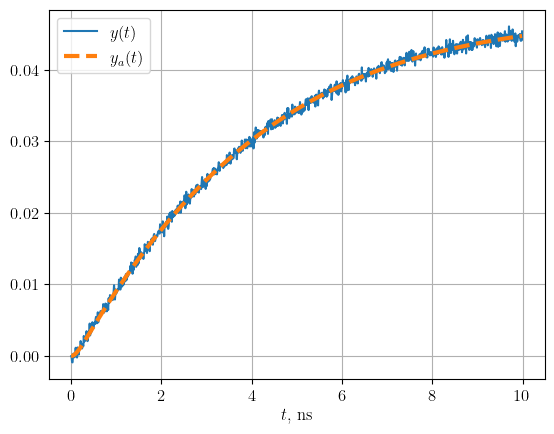

In [41]:
plt.plot(np.arange(startTime, endTime, dt), y1_history, label='$y(t)$')
plt.plot(np.arange(startTime, endTime, dt), y3_history, '--', label='$y_a(t)$', linewidth=3)
plt.xlabel('$t$, ns')
plt.grid()
plt.legend()

## Observer with approximator

In [42]:
def plant_obs_dynamics(x, x_hat, u):
    dx = A @ x + B * u + F * nonlinearity(x[0])
    dx_hat = A @ x_hat + B * u + F * approximator.predict(C@x) 
    dx_hat -= L_0 @ C @ (x - x_hat) + expm((Gd + (nu - eps) * np.eye(n)) * (1/eps) * np.log(np.linalg.norm(Ptil @ C @ (x - x_hat)))) @L_ft @ C @ (x - x_hat)
    return x + dx * dt, x_hat + dx_hat * dt

In [43]:
dt = 0.01
startTime = 0
endTime = 20
n_steps = int((endTime - startTime) / dt)
timeMoments = np.linspace(startTime, endTime, n_steps)

x0 = np.array([[0],
               [1.0]])      
x_hat0 = np.array([[0.0], 
                   [0.0]])
u_history = np.ones(n_steps) *1.2

y_history = np.zeros((n_steps, C.shape[0]))
hat_y_history = np.zeros((n_steps, C.shape[0]))
x_history = np.zeros((n_steps, n))
hat_x_history = np.zeros((n_steps, n))

x = x0
hat_x = x_hat0
while np.linalg.norm(C @ (x-hat_x)) < 1e-6:
    hat_x += np.array([[1.0],
                      [1.0]])
    
for step in range(n_steps):
    y = C @ x 
    y_history[step] = y
    x_history[step] = x.T 
    
    hat_y = C @ hat_x
    hat_y_history[step] = hat_y
    hat_x_history[step] = hat_x.T 
    
    x, hat_x = plant_obs_dynamics(x, hat_x, u_history[step])  

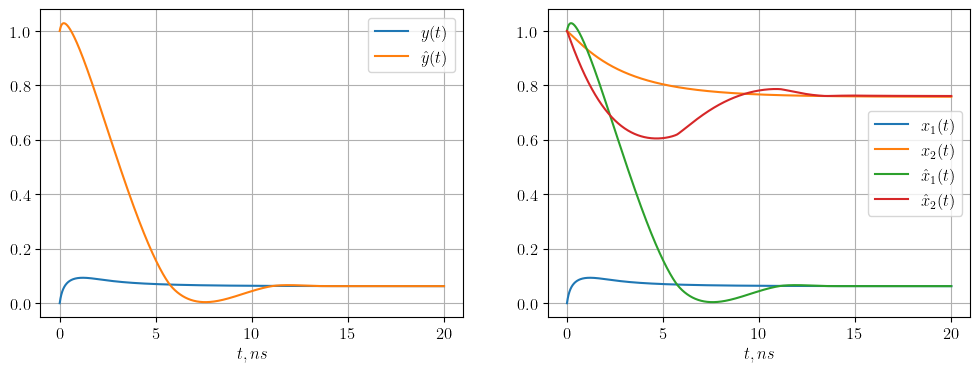

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(timeMoments, y_history, label='$y(t)$')
axs[0].plot(timeMoments, hat_y_history, label='$\hat{y}(t)$')
axs[1].plot(timeMoments, x_history[:, 0], label='$x_1(t)$')
axs[1].plot(timeMoments, x_history[:, 1], label='$x_2(t)$')
axs[1].plot(timeMoments, hat_x_history[:, 0], label='$\hat{x}_1(t)$')
axs[1].plot(timeMoments, hat_x_history[:, 1], label='$\hat{x}_2(t)$')
for ax in axs:
    ax.set_xlabel('$t, ns$')
    ax.grid()
    ax.legend()

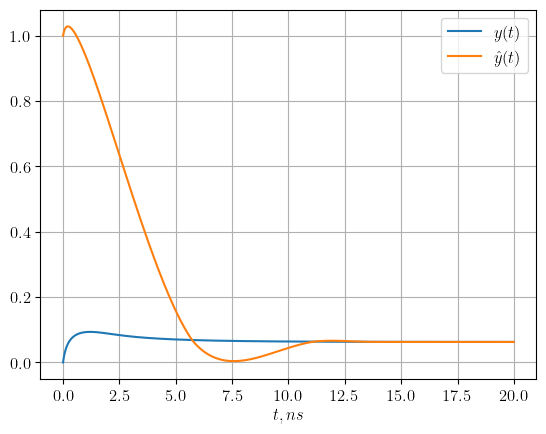

In [45]:
plt.plot(timeMoments, y_history, label='$y(t)$')
plt.plot(timeMoments, hat_y_history, label='$\hat{y}(t)$')
plt.grid()
plt.legend()
plt.xlabel('$t, ns$')
plt.savefig('outputs.png')

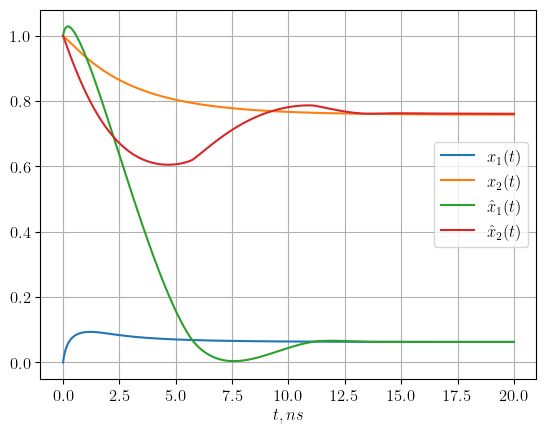

In [46]:
plt.plot(timeMoments, x_history[:, 0], label='$x_1(t)$')
plt.plot(timeMoments, x_history[:, 1], label='$x_2(t)$')
plt.plot(timeMoments, hat_x_history[:, 0], label='$\hat{x}_1(t)$')
plt.plot(timeMoments, hat_x_history[:, 1], label='$\hat{x}_2(t)$')
plt.grid()
plt.legend()
plt.xlabel('$t, ns$')
plt.savefig('states.png')

## Comparison with linear observer

In [47]:
def plant_2obs_dynamics(x, x_hat, x_bar, u):
    dx = A @ x + B * u + F * nonlinearity(x[0])
    dx_hat = A @ x_hat + B * u + F * approximator.predict(C@x) 
    dx_hat -= L_0 @ C @ (x - x_hat) + expm((Gd + (nu - eps) * np.eye(n)) * (1/eps) * np.log(np.linalg.norm(Ptil @ C @ (x - x_hat)))) @L_ft @ C @ (x - x_hat)
    dx_bar = A @ x_bar + B * u - (L_0 + L_ft) @ C @ (x - x_bar) + F * approximator.predict(C@x) 
    return x + dx * dt, x_hat + dx_hat * dt, x_bar + dx_bar * dt

In [48]:
y_history = np.zeros((n_steps, C.shape[0]))
hat_y_history = np.zeros((n_steps, C.shape[0]))
bar_y_history = np.zeros((n_steps, C.shape[0]))
x_history = np.zeros((n_steps, n))
hat_x_history = np.zeros((n_steps, n))
bar_x_history = np.zeros((n_steps, n))

x = x0
hat_x = x_hat0
bar_x = x_hat0.copy()
while np.linalg.norm(C @ (x-hat_x)) < 1e-6:
    hat_x += np.array([[1.0],
                      [1.0]])
    
for step in range(n_steps):
    y = C @ x 
    y_history[step] = y
    x_history[step] = x.T
    
    hat_y = C @ hat_x
    hat_y_history[step] = hat_y
    hat_x_history[step] = hat_x.T 
    
    bar_y = C @ bar_x
    bar_y_history[step] = bar_y
    bar_x_history[step] = bar_x.T 
    
    x, hat_x, bar_x = plant_2obs_dynamics(x, hat_x, bar_x, u_history[step])  
    
bar_e = y_history - bar_y_history
hat_e = y_history - hat_y_history

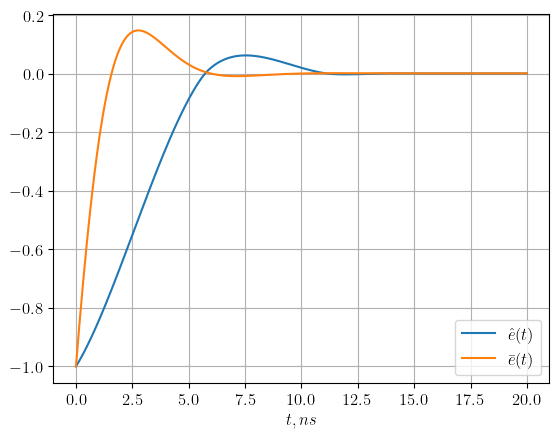

In [49]:
plt.plot(timeMoments, hat_e, label='$\hat{e}(t)$')
plt.plot(timeMoments, bar_e, label='$\\bar{e}(t)$')
plt.grid()
plt.legend()
plt.xlabel('$t, ns$')
plt.savefig('error_y.png')

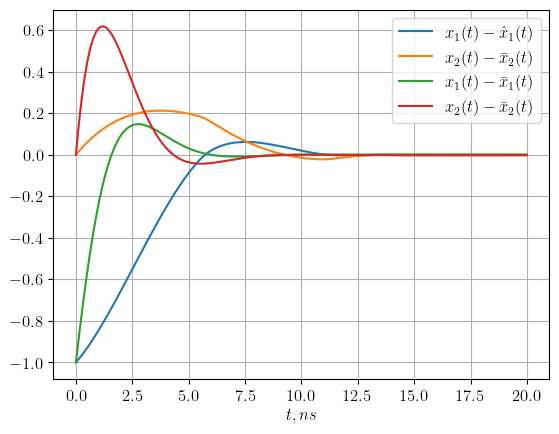

In [50]:
plt.plot(timeMoments, x_history[:, 0] - hat_x_history[:, 0], label='$x_1(t) - \hat{x}_1(t)$')
plt.plot(timeMoments, x_history[:, 1] - hat_x_history[:, 1] , label='$x_2(t) - \\bar{x}_2(t)$')
plt.plot(timeMoments, x_history[:, 0] - bar_x_history[:, 0], label='$x_1(t) - \\bar{x}_1(t)$')
plt.plot(timeMoments, x_history[:, 1] - bar_x_history[:, 1] , label='$x_2(t) - \\bar{x}_2(t)$')
plt.grid()
plt.legend()
plt.xlabel('$t, ns$')
plt.savefig('error_x.png')